In [1]:
###############
# 1. import
#####

# DB접속
import os
from os import listdir
import cx_Oracle as oci
import numpy as np
import pandas as pd

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib_venn import venn3
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


# RFM 계산
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
from lifetimes.utils import summary_data_from_transaction_data


# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta


# 내용공유(e-mail, 회사) 
from jinja2 import Template
import win32com.client
from glob import glob
import io
import base64
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()


# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

In [3]:
###############
# 1.데이터 불러오기 : 월별 누적방문인원, 3년 비교
#####


# query run
query1 = '''
    select REG_YY, REG_MM, sum(방문자수) over (order by REG_MM) as CNT 
    from (
        select REG_YY, REG_MM, count(*) as 방문자수
        from (
            select unfy_mmb_no, REG_YY, min(REG_MM) as REG_MM 
            from (
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where COOPCO_CD in('7060') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                group by unfy_mmb_no
                union all
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where  COOPCO_CD in ('7060') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                group by unfy_mmb_no
                union all
                select A.unfy_mmb_no, to_char(min(A.upd_dtm), 'YYYY') as REG_YY, to_char(min(A.upd_dtm), 'MM') as REG_MM
                from mmbship.TPM_CPN_ISSU A, TPM_CPN B
                where B.use_coopco_cd in ('7060') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                group by A.unfy_mmb_no
                union all
                select M.unfy_mmb_no, to_char(min(U.REG_DT), 'YYYY') as REG_YY, to_char(min(U.REG_DT), 'MM') as REG_MM
                from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                where U.coopco_cd in('7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
                group by M.unfy_mmb_no
                ) group by unfy_mmb_no, REG_YY
            ) group by REG_YY, REG_MM
        )
    '''
df1_A = pd.read_sql(query1, con = conn )
df1_A['REG_MM'] = df1_A['REG_MM'] + '월'

query2 = '''
    select REG_YY, REG_MM, sum(방문자수) over (order by REG_MM) as CNT 
    from (
        select REG_YY, REG_MM, count(*) as 방문자수
        from (
            select unfy_mmb_no, REG_YY, min(REG_MM) as REG_MM 
            from (
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where COOPCO_CD in('7060') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-365, 'YYYY')
                group by unfy_mmb_no
                union all
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where  COOPCO_CD in ('7060') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-365, 'YYYY')
                group by unfy_mmb_no
                union all
                select A.unfy_mmb_no, to_char(min(A.upd_dtm), 'YYYY') as REG_YY, to_char(min(A.upd_dtm), 'MM') as REG_MM
                from mmbship.TPM_CPN_ISSU A, TPM_CPN B
                where B.use_coopco_cd in ('7060') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate-365, 'YYYY')
                group by A.unfy_mmb_no
                union all
                select M.unfy_mmb_no, to_char(min(U.REG_DT), 'YYYY') as REG_YY, to_char(min(U.REG_DT), 'MM') as REG_MM
                from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                where U.coopco_cd in('7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate-365, 'YYYY') and U.use_amt > 0
                group by M.unfy_mmb_no
                ) group by unfy_mmb_no, REG_YY
            ) group by REG_YY, REG_MM
        )
    '''
df1_B = pd.read_sql(query2, con = conn )
df1_B['REG_MM'] = df1_B['REG_MM'] + '월'

query3 = '''
    select REG_YY, REG_MM, sum(방문자수) over (order by REG_MM) as CNT 
    from (
        select REG_YY, REG_MM, count(*) as 방문자수
        from (
            select unfy_mmb_no, REG_YY, min(REG_MM) as REG_MM 
            from (
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where COOPCO_CD in('7060') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-730, 'YYYY')
                group by unfy_mmb_no
                union all
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where  COOPCO_CD in ('7060') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-730, 'YYYY')
                group by unfy_mmb_no
                union all
                select A.unfy_mmb_no, to_char(min(A.upd_dtm), 'YYYY') as REG_YY, to_char(min(A.upd_dtm), 'MM') as REG_MM
                from mmbship.TPM_CPN_ISSU A, TPM_CPN B
                where B.use_coopco_cd in ('7060') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate-730, 'YYYY')
                group by A.unfy_mmb_no
                union all
                select M.unfy_mmb_no, to_char(min(U.REG_DT), 'YYYY') as REG_YY, to_char(min(U.REG_DT), 'MM') as REG_MM
                from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                where U.coopco_cd in('7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate-730, 'YYYY') and U.use_amt > 0
                group by M.unfy_mmb_no
                ) group by unfy_mmb_no, REG_YY
            ) group by REG_YY, REG_MM
        )
    '''
df1_C = pd.read_sql(query3, con = conn )
df1_C['REG_MM'] = df1_C['REG_MM'] + '월'


df1 = pd.concat([df1_A, df1_C, df1_B], ignore_index=True)
report_01 = pd.pivot_table(df1, values='CNT', index=['REG_MM'],columns=['REG_YY'],  aggfunc='sum')
pd.options.display.float_format = '{:0,.0f}'.format


In [4]:
report_01

REG_YY,2021,2022,2023
REG_MM,,,
01월,36,33,49
02월,80,64,371
03월,87,78,690
04월,91,123,691
05월,146,161,NaN
06월,251,172,NaN
07월,264,182,NaN
08월,272,246,NaN
09월,286,277,NaN


In [5]:

###############
# B. 누적방문 횟수 : 1~6+ 기준
#####

# 쿼리비교 : 월별 이용 기준
query4 ='''
select unfy_mmb_no, REG_DM, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun) AS service
from (
    select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
    from TP_TRSC_PTCL
    where COOPCO_CD in('7060') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
    from TP_TRSC_PTCL
    where  COOPCO_CD in ('7060') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, to_char(A.upd_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
    from mmbship.TPM_CPN_ISSU A, TPM_CPN B
    where B.use_coopco_cd in ('7060') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
    from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
    where U.coopco_cd in('7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
)
GROUP BY unfy_mmb_no, REG_DM
'''
df1_D =  pd.read_sql(query4, con = conn )
df1_D['VISIT_COUNT'] = df1_D.groupby('UNFY_MMB_NO').cumcount(ascending=True)+1
df1_D['CNT'] = 1


# 기간간 누락 자료 추가
cumsum_count = df1_D.groupby('UNFY_MMB_NO').apply(lambda x: pd.Series(x['CNT'].count() ,index=x['REG_DM']))
try:
    cumsum_count = cumsum_count.unstack(level=1).fillna(method='ffill', axis=1)
except:
    pass
cumsum_count = cumsum_count.unstack(level=0)

df_temp = pd.DataFrame(cumsum_count).reset_index()

df1_vf = pd.merge(df_temp, df1_D, on =['UNFY_MMB_NO', 'REG_DM'], how = 'left').reset_index(drop=True)
df1_vf.rename(columns = {0: 'CHECK'}, inplace = True)

df1_vf = df1_vf.sort_values(by=['UNFY_MMB_NO', 'REG_DM'], ascending=True).reset_index(drop=True)
df1_vf = df1_vf[df1_vf.CHECK >= 1.0].reset_index(drop=True)

df1_vf['VISIT_COUNT']= df1_vf['VISIT_COUNT'].fillna(method='pad')
df1_vf['SERVICE']= df1_vf['SERVICE'].fillna(method='pad')

df1_vf = df1_vf[['UNFY_MMB_NO', 'REG_DM', 'SERVICE', 'VISIT_COUNT']]

df1_vf = df1_vf.dropna().reset_index(drop=True)
df1_vf.loc[df1_vf["VISIT_COUNT"] >= 6, 'VISIT_COUNT' ] = '6+'




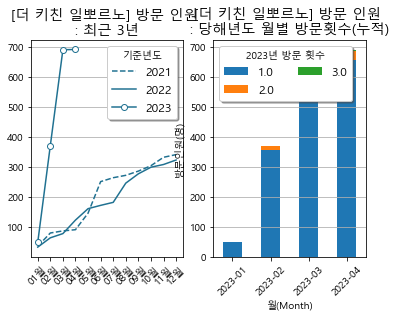

In [6]:


mpl.rc('figure', figsize=(13, 6))

ax1 = plt.subplot(1,2,1)
plt.plot(report_01[report_01.columns[0]], '--', color = '#207191', label=report_01.columns[0])
plt.plot(report_01[report_01.columns[1]], '-',  color = '#207191', label=report_01.columns[1])
plt.plot(report_01[report_01.columns[2]], color = '#207191', label=report_01.columns[2], marker= "o", markerfacecolor ='w')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.legend(loc='best', fancybox=True, shadow=True, ncol= 1, fontsize='large').set_title("기준년도")
plt.title('[더 키친 일뽀르노] 방문 인원 \n: 최근 3년',fontsize='x-large')

ax2 = plt.subplot(1,2,2)
pd.crosstab(df1_vf.REG_DM, df1_vf.VISIT_COUNT, df1_vf.UNFY_MMB_NO, aggfunc="count").plot.bar(stacked=True, ax = ax2)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.24), fancybox=True, shadow=True, ncol=4).set_title("방문횟수(건)")
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol= 2, fontsize='large').set_title("2023년 방문 횟수")
# plt.axvspan(10.5, 12.5, color='gray', alpha=0.3)
# plt.axvspan(12.5, 15.5, color='red', alpha=0.2)
# plt.ylim(0, 1200)
plt.grid(True, axis='y')
plt.title('[더 키친 일뽀르노] 방문 인원 \n: 당해년도 월별 방문횟수(누적)',fontsize='x-large')
plt.xticks(rotation=45)
plt.xlabel('월(Month)')
plt.ylabel('방문인원(명)')

date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_CNT01_report_ILP.png'
plt.savefig(image_name, bbox_inches='tight',  facecolor='#eeeeee', dpi=70)



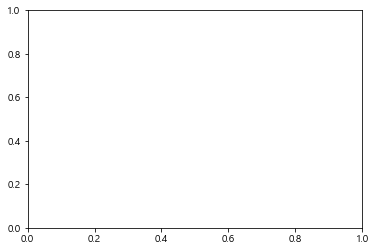

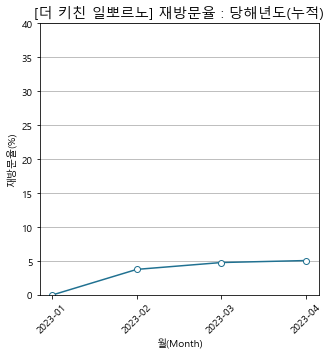

In [7]:

# 누적 방문자수 시각화
df_tt = pd.crosstab(df1_vf.REG_DM, df1_vf.VISIT_COUNT, df1_vf.UNFY_MMB_NO, aggfunc="count", margins= True, margins_name = 'Total(22Y)')[:-1]
df_tt = df_tt.fillna('')

report_02B = round((df_tt[df_tt.columns[-1]] - df_tt[df_tt.columns[0]]) / df_tt[df_tt.columns[-1]]*100,2)
Return_rate = report_02B[-1]

plt.cla()
mpl.rc('figure', figsize=(5, 5))
fig = plt.figure()
plt.plot(report_02B, marker= "o", markerfacecolor ='w', color = '#207191')
plt.grid(True, axis='y')
plt.ylim(0, 40)
plt.title('[더 키친 일뽀르노] 재방문율 : 당해년도(누적)',fontsize='x-large')
plt.xticks(rotation=45)
plt.xlabel('월(Month)')
plt.ylabel('재방문율(%)')

image_name = date2[2:] +'_CNT02_report_ILP.png'
plt.savefig(image_name, bbox_inches='tight', facecolor='#eeeeee', dpi=70)

<Figure size 432x432 with 0 Axes>

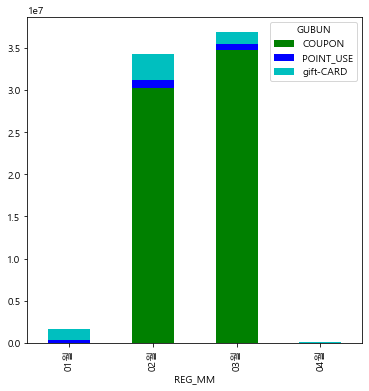

In [8]:

###############
# 3.데이터 불러오기 : Maeil Do 서비스별 매출기여 금액
#####


# 쿼리비교 : 단일합
query5B = '''select REG_YY, REG_MM, gubun
            , sum(누적방문자수) as CNT
            , sum(tot_sale_amt) as AMT
            from (select REG_YY, REG_MM, gubun, count(*) as 누적방문자수, sum(tot_sale_amt) as tot_sale_amt
                from (select unfy_mmb_no, REG_YY, gubun, max(REG_MM) as REG_MM, sum(tot_sale_amt) as tot_sale_amt
                    from (
                        select unfy_mmb_no, to_char(reg_dtm, 'YYYY') as REG_YY, to_char(reg_dtm, 'MM') as REG_MM, tot_sel_amt as tot_sale_amt, 'POINT_USE' as gubun
                        from TP_TRSC_PTCL
                        where  COOPCO_CD in ('7060') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                        union all
                        select A.unfy_mmb_no, to_char(A.upd_dtm, 'YYYY') as REG_YY, to_char(A.upd_dtm, 'MM') as REG_MM, T.tot_sel_amt as tot_sale_amt, 'COUPON' as gubun
                        from mmbship.TPM_CPN_ISSU A, TPM_CPN B, TP_TRSC_PTCL T, tpm_cpn_use U 
                        where B.use_coopco_cd in ('7060') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY') and U.apv_no = T.apv_no and T.trsc_typ_cd = '600' and U.cpn_issu_cd = A.cpn_issu_Cd
                        union all
                        select M.unfy_mmb_no, to_char(U.REG_DT, 'YYYY') as REG_YY, to_char(U.REG_DT, 'MM') as REG_MM, U.use_amt as tot_sale_amt, 'gift-CARD' as gubun
                        from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                        where U.coopco_cd in('7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
                        )
                    group by unfy_mmb_no, REG_YY, gubun
                    )
                group by REG_YY, REG_MM, gubun
                )
            group by REG_YY, REG_MM, gubun'''
df5B =  pd.read_sql(query5B, con = conn )
df5B['REG_MM'] = df5B['REG_MM'] + '월'

report_02 = pd.pivot_table(df5B, values='AMT', index=['REG_MM'],columns=['GUBUN'],  aggfunc='sum').fillna(0)
pd.options.display.float_format = '{:0,.0f}'.format


mpl.rc('figure', figsize=(6, 6))
fig = plt.figure()


colors = ['g', 'b',  'c']
report_02.plot(kind='bar', stacked=True, figsize=(6, 6), color=colors)
pd.options.display.float_format = '{:0,.0f}'.format

# plt.title('[크리스탈 제이드] : 서비스별 기여매출액',fontsize='x-large')

date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_AMT_report_ILP.png'
plt.savefig(image_name, bbox_inches='tight',  facecolor='#eeeeee', dpi=70)

In [9]:
###############
# 2.데이터 불러오기 : 프로모션 결과
#####

query = '''
    select M.CPN_CD   AS 쿠폰코드
    , (case when M.USE_COOPCO_CD=7060 then 'ILP' when M.USE_COOPCO_CD=7050 then 'CYK' else 'PBS' end )AS 관계사
    , (select code_nm from JT_CODE  where code_grp_id = 'CM041' and M.OFFR_TYP_CD=code)   AS 쿠폰유형
    , M.CPN_NM        AS 쿠폰이름
    , M.APCL_STR_DT   AS 시작일자
    --, substr(M.APCL_STR_DT,1,6)   AS 시작일자_구분
    , M.APCL_END_DT   AS 종료일자
    , (case when M.APCL_END_DT > to_char(sysdate-1, 'YYYYMMDD') then '진행중' else '종료' end) as "진행여부"
    , nvl(D1.click_cnt, D2.click_cnt) as "베너클릭(명)"
    , A.발급인원 as "발급인원(명)"
    , B.사용인원 as "사용인원(명)"
    , round(B.사용인원/A.발급인원,4)*100 as "사용율(발급대비,%)" 
    , (case when c.first_user_cnt is null then 0 else c.first_user_cnt end)as "사용인원_첫구매(명)"
    , B.사용인원 - (case when c.first_user_cnt is null then 0 else c.first_user_cnt end) as "사용인원_재구매(명)"
    , B.총결제금액 as "총결제금액(원)"
    , B.할인금액 as "할인금액(원)"
    , B.사용일자 as "최종사용일"
    from mmbship.TPM_CPN M

      --A. 다운로드 인원*
      left join (select cpn_cd
      , count(*) as 발급인원
      from mmbship.TPM_CPN_ISSU
      where unfy_mmb_no is not null
      group by cpn_cd
      ) A
      on M.cpn_cd = A.cpn_cd

      --B. 사용 및 할인 금액
      left join (select I.cpn_cd
      , count(I.unfy_mmb_no) as 사용인원
       , sum(P.tot_sel_amt) as 총결제금액
       , sum(U.DC_AMT) as 할인금액
       , max(U.apv_dt) as 사용일자
       from mmbship.TPM_CPN_use U, mmbship.TPM_CPN_ISSU I, tp_trsc_ptcl P
       where I.CPN_ISSU_CD = U.CPN_ISSU_CD
       and P.apv_no = U.apv_no
       and I.cpn_st_cd ='2'
       and U.can_apv_dt is null
       group by I.cpn_cd
      ) B
      on M.cpn_cd = B.cpn_cd

      --C.당해년도 첫구매/재구매 인원
      left join (
        with cpn_user as (
            select unfy_mmb_no, min(use_dtm) as use_dtm from (
            select I.unfy_mmb_no, I.cpn_cd, trunc(I.upd_dtm) as use_dtm
            from tpm_cpn_issu I , tpm_cpn C 
            where I.cpn_st_cd = '2'
            and I.cpn_cd = C.cpn_Cd
            and I.cpn_Cd not like 'PBS%'
            and C.use_coopco_Cd = 7060
            and to_char(C.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            and to_char(I.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            ) group by unfy_mmb_no),
        cpn_cd_user as (
            select I.unfy_mmb_no, I.cpn_cd,  C.use_coopco_Cd, trunc(I.upd_dtm) as use_dtm
            from tpm_cpn_issu I , tpm_cpn C 
            where I.cpn_st_cd = '2'
            and I.cpn_cd = C.cpn_Cd
            and I.cpn_Cd not like 'PBS%'
            and C.use_coopco_Cd = 7060
            and to_char(C.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            and to_char(I.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY') )
        select  A.cpn_Cd, A.use_coopco_Cd, count(*) as first_user_cnt
        from cpn_user U, cpn_cd_user A
        where a.unfy_mmb_no = U.unfy_mmb_no
        and A.use_dtm = U.use_dtm
        group by A.cpn_Cd, A.use_coopco_Cd
      ) C
      on M.cpn_cd = C.cpn_cd


      --D1. 일뽀르노 베너클릭 인원 
      left join (select T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
            from tch_evnt_click_log g, tch_evnt T
            where G.evnt_no = T.evnt_no
            and (T.evnt_tite like '%일뽀르노%' or T.evnt_tite like '%발렌타인%')
            group by  T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt
      ) D1
      on D1.evnt_str_dt = M.APCL_STR_DT
      and D1.evnt_end_dt = M.APCL_END_DT
      and  M.USE_COOPCO_CD=7060

      --D2. 크리스탈 제이드 베너클릭 인원 
      left join (
            select T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
            from tch_evnt_click_log g, tch_evnt T
            where G.evnt_no = T.evnt_no
            and T.evnt_tite like '%크리스탈%' 
            group by  T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt
            union all
            select T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
            from tch_evnt_click_log g, tch_evnt T
            where G.evnt_no = T.evnt_no
            and T.evnt_tite like '%시즌메뉴%' 
            group by  T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt
      ) D2
      on D2.evnt_str_dt = M.APCL_STR_DT
      and D2.evnt_end_dt = M.APCL_END_DT
      and M.USE_COOPCO_CD=7050

    where M.USE_YN ='Y'
    --AND M.CUR_ISSU_QNT IS NOT NULL
    and M.APCL_END_DT not in (29991231, 99991231, 20170807, 20171203, 20171209)
    ORDER BY M.APCL_STR_DT, M.CPN_CD
'''

df = pd.read_sql(query, con = conn )
df['최종사용일'] = pd.to_datetime(df['최종사용일'],format = '%Y-%m-%d')
df['시작일자'] = pd.to_datetime(df['시작일자'],format = '%Y-%m-%d')
df['종료일자'] = pd.to_datetime(df['종료일자'],format = '%Y-%m-%d')

report_03 = df[(df['시작일자'] >= '20230101' )&(df['관계사'] == 'ILP') ].reset_index(drop=True)
report_03 = report_03.drop_duplicates().reset_index(drop=True)
pd.options.display.float_format = '{:0,.0f}'.format

In [22]:
###############
# 2.데이터 불러오기 : 서비스별 이용결과
#####

query = '''
    with employee_list as 
        ( select distinct unfy_mmb_no, 'Y' as gubun
        from mmbship.tpr_crd_mstr
        where crd_kind = '998')

    --쿠폰 사용
    select I.unfy_mmb_no
    , '쿠폰 사용' as TRSC_TYP_CD , U.coopco_CD, U.dc_amt as USE_AMT, U.dc_tgt_amt as TOT_SEL_AMT, U.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.tpm_cpn_use U, mmbship.tpm_cpn_issu C, employee_list E, tm_mmb_info I
    where C.unfy_mmb_no = I.unfy_mmb_no 
    and C.unfy_mmb_no = E.unfy_mmb_no(+)
    and C.cpn_issu_cd = U.cpn_issu_cd
    and C.cpn_st_Cd = '2'
    and U.coopco_CD in ('7050', '7060') 
    and I.mmb_st_cd = '1'
    and C.unfy_mmb_no not in ('443986')
    --and to_char(U.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    and U.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -4 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )           
    union all
    --포인트 적립/사용
    select T.unfy_mmb_no
    , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
    , T.coopco_cd, (case when acml_pint = 0 then use_pint else acml_pint end) as use_amt , T.tot_sel_amt, T.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.TP_TRSC_PTCL T, employee_list E, tm_mmb_info I
    where T.unfy_mmb_no is not null 
    and T.tot_sel_amt > 0 
    and T.unfy_mmb_no = I.unfy_mmb_no 
    and I.mmb_st_cd = '1'
    and T.unfy_mmb_no = E.unfy_mmb_no(+)
    --and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    and T.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -4 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
    and T.trsc_typ_cd in ( '200', '300')
    and T.COOPCO_CD in ('7050', '7060')
    union all
    --기프트카드사용
    select T.unfy_mmb_no
    , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
    , T.coopco_cd, H.use_amt, T.tot_sel_amt, T.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.TP_TRSC_PTCL T, employee_list E, mmbship.tm_mmb_info I, mmbship.tpr_crd_actv_amt_use_hist H
    where T.unfy_mmb_no is not null 
    and T.tot_sel_amt > 0 
    and H.use_idx = T.apv_no
    and T.unfy_mmb_no = I.unfy_mmb_no 
    and I.mmb_st_cd = '1'
    and T.unfy_mmb_no = E.unfy_mmb_no(+)
    --and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    and T.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -4 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
    and T.trsc_typ_cd in ( 'G40')
    and T.COOPCO_CD in ('7050', '7060')
        '''
df_all = pd.read_sql(query, con = conn )
df_all['UNFY_MMB_NO'] = df_all['UNFY_MMB_NO'].astype(object)
# 임직원 제외
df_all = df_all[df_all['GUBUN']=='N'].reset_index(drop=True)

# 분석 대상 관계사 지정
df = df_all[df_all.COOPCO_CD =='7060'].reset_index(drop=True)


In [25]:
# RFM 계산
period_end_date = (datetime.today()+ timedelta(days=-1))
rfm = df.groupby('UNFY_MMB_NO').agg({'REG_DTM': lambda date: (period_end_date - date.max()).days, # Recency calclation
                                     'UNFY_MMB_NO': lambda num: num.count(), # Frequency calculation
                                     'TOT_SEL_AMT': lambda TotalPrice: TotalPrice.sum()}) # Monetary calculation

rfm.columns = ['Recency', 'Frequency', 'Monetary'] # Changing column names

# Converting
rfm['recency_score']   = pd.qcut(rfm['Recency'], 5, [5, 4, 3, 2,1])
rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, [1, 2, 3, 4, 5]) 
rfm['monetary_score']  = pd.qcut(rfm['Monetary'], 5, [1, 2, 3, 4, 5], duplicates = 'drop')
# rfm['monetary_score']  = pd.qcut(rfm['Monetary'], q = 5, labels = [1,2,3,4,5], duplicates = 'drop')

# Calculating RFM score
rfm['RFM_SCORE'] = (rfm['recency_score'].astype('str') + rfm['frequency_score'].astype('str'))

seg_map = {
    r'[1-2][1-2]': '10.hibernating', # For instance means: If F is 1 or 2 and If R is 1 or 2 give hibernating 
    r'[1-2]5': '09.cant_loose',
    r'[1-2][3-4]': '08.at_Risk',
    r'3[1-2]': '07.about_to_sleep',
    r'33': '06.need_attention',
    r'41': '05.promising',
    r'51': '04.new_customers',
    r'[4-5][2-3]': '03.potential_loyalists',
    r'[3-4][4-5]': '02.loyal_customers',
    r'5[4-5]': '01.champions'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm2 = pd.merge(rfm, df[['UNFY_MMB_NO', 'AGE']].drop_duplicates(), left_on='UNFY_MMB_NO', right_on='UNFY_MMB_NO', how='left')

summary = summary_data_from_transaction_data(df, 'UNFY_MMB_NO', 'REG_DTM', observation_period_end=df.REG_DTM.max().strftime('%Y-%m-%d'))
summary = summary.reset_index()
rfm_lifetime = rfm2[['UNFY_MMB_NO', 'segment']]

summary = pd.merge( summary, rfm_lifetime, on ='UNFY_MMB_NO', how ='left')


ValueError: Bin labels must be one fewer than the number of bin edges

In [21]:
rfm.Monetary

UNFY_MMB_NO
407723      54000
666052     259600
693601      69000
746992     164000
920689     564000
            ...  
6815345     22000
6815365     22000
6815723     19000
6815843     22000
6815916    719000
Name: Monetary, Length: 840, dtype: int64

In [34]:
# summary.groupby('frequency').count()

In [ ]:
# 예측값 모델링
# BGF 모형 : 예상 방문 비율 추정
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
data = summary.copy()

t = 15
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
BGF_15t = list(data.groupby('segment')['predicted_purchases'].mean())

t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
BGF_30t = list(data.groupby('segment')['predicted_purchases'].mean())



# Gamma/Gamma 모형 : 예상 사용금액 추정
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm2['Frequency'], rfm2['Monetary'])

ggf.conditional_expected_average_profit(rfm2['Frequency'], rfm2['Monetary']).head(10)
ggf.conditional_expected_average_profit(rfm2['Frequency'], rfm2['Monetary']).sort_values(ascending=False).head(10)

rfm2["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm2['Frequency'],rfm2['Monetary'])


In [ ]:
# 최종 결과 정리
report_04 = pd.pivot_table(rfm2, 
                         values=['Monetary',  'Frequency', 'expected_average_profit','AGE'], 
                         index=['segment'],  
                         aggfunc=np.mean).fillna(0)


report_04 = report_04.reset_index()
report_04['Monetary(Pred.)'] = report_04['expected_average_profit'] - report_04['Monetary']
report_04['Frequency(Pred.)'] = BGF_30t

report_04['COUNT'] = list(summary.groupby('segment')['T'].count())
report_04 = report_04[['segment','AGE','COUNT', 'Frequency', 'Monetary','Frequency(Pred.)', 'Monetary(Pred.)', ]]
pd.options.display.float_format = '{:0,.1f}'.format


# 코멘트 추가
group_ = '01.champions'
value1 = report_04[report_04.segment ==group_]['COUNT'].values[0]
value2 = report_04[report_04.segment ==group_]['Frequency'].values[0]
value3 = report_04[report_04.segment ==group_]['Monetary'].values[0]

value5 = report_04[report_04.segment ==group_]['Frequency(Pred.)'].values[0]*100
value6 =report_04[report_04.segment ==group_]['Monetary(Pred.)'].values[0]

comment1 = '[{}] 등급에 해당되는 인원은 {:0,.0f}명이며, 기간 내 {:0,.1f}회 방문하는 동안, 1인당 총 {:0,.0f}원(기간누적)을 사용하였다.'.format(group_, value1, value2, value3)
comment2 = '해당 등급 인원은, {:0,.1f}% 정도가 30일 이내 (1회)재방문 할 것으로 보이며, 이 때 {:0,.0f}원 상당의 추가 구매가 발생할 것으로 예측됨'.format(value5, value6)


group_ = '10.hibernating'
value1 = report_04[report_04.segment ==group_]['COUNT'].values[0]
value2 = report_04[report_04.segment ==group_]['Frequency'].values[0]
value3 = report_04[report_04.segment ==group_]['Monetary'].values[0]

value5 = report_04[report_04.segment ==group_]['Frequency(Pred.)'].values[0]*100
value6 =report_04[report_04.segment ==group_]['Monetary(Pred.)'].values[0]

comment3 = '반면, [{}] 등급에 해당되는 인원은 {:0,.0f}명이며, 기간 내 {:0,.1f}회 방문하는 동안, 1인당 총 {:0,.0f}원(기간누적)을 사용하였다.'.format(group_, value1, value2, value3)
comment4 = '해당 등급 인원은, {:0,.1f}% 정도가 30일 이내 (1회)재방문 할 것으로 보이며, 이 때 {:0,.0f}원 상당의 추가 구매가 발생할 것으로 예측됨'.format(value5, value6)


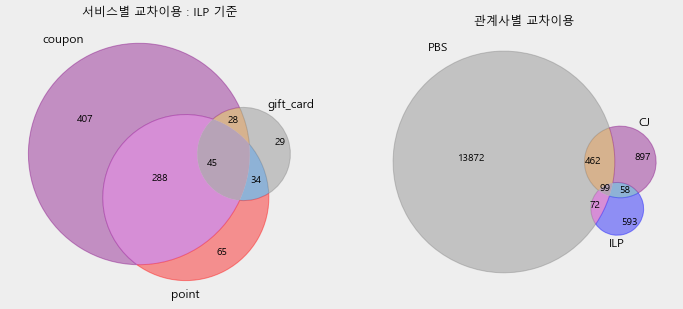

In [26]:
###############
# E1.서비스 이용 인원 : venn
#####

# 쿼리비교 : 일별 이용 기준
query_service ='''
    select service, count(*) as CNT from(
    select unfy_mmb_no, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no) AS service
    from (
        select distinct unfy_mmb_no, (case when gubun like '%point_%' then 'point' else gubun end) as gubun
        from (
            select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
            from TP_TRSC_PTCL
            where COOPCO_CD in('7060') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
            from TP_TRSC_PTCL
            where  COOPCO_CD in ('7060') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, to_char(A.upd_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
            from mmbship.TPM_CPN_ISSU A, TPM_CPN B
            where B.use_coopco_cd in ('7060') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
            from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
            where U.coopco_cd in('7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
        )
    )
    ) group by service
    '''
df_cross_by_service =  pd.read_sql(query_service, con = conn )

# 기준 테이블 생성
data = ['coupon', 'coupon,gift_card',  'coupon,gift_card,point', 'coupon,point', 'gift_card', 'gift_card,point', 'point']
df_cross_by_service_t = pd.DataFrame(data, columns=['SERVICE'])

# merge
df_cross_by_service =pd.merge(df_cross_by_service_t,df_cross_by_service, on = 'SERVICE', how ='left' ).fillna(0)


###############
# E2.관계사 이용 인원 : venn
#####


# 쿼리비교 : 관계사 교차이용 분석
query ='''
select BRAND, count(*) as CNT from(
select unfy_mmb_no, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no) AS BRAND
from (
    select distinct unfy_mmb_no,  gubun
    from (
        select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, COOPCO_CD AS gubun
        from TP_TRSC_PTCL
        where COOPCO_CD in('7050', '7060', '7030') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, COOPCO_CD AS gubun
        from TP_TRSC_PTCL
        where  COOPCO_CD in ('7050', '7060', '7030') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, to_char(A.upd_dtm, 'YYYY-MM') as REG_DM, B.use_coopco_cd AS gubun
        from mmbship.TPM_CPN_ISSU A, TPM_CPN B
        where B.use_coopco_cd in ('7050', '7060', '7030') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM, U.coopco_cd AS gubun
        from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
        where U.coopco_cd in('7050', '7060', '7030') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
    )
)
) group by BRAND
'''
df_cross_by_brand =  pd.read_sql(query, con = conn )

# 기준 테이블 생성
data = ['7030', '7030,7050',  '7030,7050,7060', '7030,7060', '7050', '7050,7060', '7060']
df_cross_by_brand_t = pd.DataFrame(data, columns=['BRAND'])

# merge
df_cross_by_brand =pd.merge(df_cross_by_brand_t, df_cross_by_brand, on = 'BRAND', how ='left' ).fillna(0)


# Import the library
mpl.rc('figure', figsize=(12, 6), facecolor='#eeeeee')
ax1 = plt.subplot(1,2,1)
c= venn3(subsets = (df_cross_by_service[df_cross_by_service.SERVICE == 'coupon']['CNT'].values[0],
                    df_cross_by_service[df_cross_by_service.SERVICE == 'gift_card']['CNT'].values[0],
                    df_cross_by_service[df_cross_by_service.SERVICE == 'coupon,gift_card']['CNT'].values[0],
                    df_cross_by_service[df_cross_by_service.SERVICE == 'point']['CNT'].values[0],
                    df_cross_by_service[df_cross_by_service.SERVICE == 'coupon,point']['CNT'].values[0],
                    df_cross_by_service[df_cross_by_service.SERVICE == 'gift_card,point']['CNT'].values[0],
                    df_cross_by_service[df_cross_by_service.SERVICE == 'coupon,gift_card,point']['CNT'].values[0]), 
         set_labels = ('coupon', 'gift_card', 'point'))
c.get_patch_by_id('100').set_color('purple')
c.get_patch_by_id('010').set_color('gray')
c.get_patch_by_id('001').set_color('red')
plt.title('서비스별 교차이용 : ILP 기준')

ax2 = plt.subplot(1,2,2)
c= venn3(subsets = (df_cross_by_brand[df_cross_by_brand.BRAND == '7030']['CNT'].values[0],
                    df_cross_by_brand[df_cross_by_brand.BRAND == '7050']['CNT'].values[0],
                    df_cross_by_brand[df_cross_by_brand.BRAND == '7030,7050']['CNT'].values[0],
                    df_cross_by_brand[df_cross_by_brand.BRAND == '7060']['CNT'].values[0],
                    df_cross_by_brand[df_cross_by_brand.BRAND == '7030,7060']['CNT'].values[0],
                    df_cross_by_brand[df_cross_by_brand.BRAND == '7050,7060']['CNT'].values[0],
                    df_cross_by_brand[df_cross_by_brand.BRAND == '7030,7050,7060']['CNT'].values[0]), 
         set_labels = ('PBS', 'CJ', 'ILP'))
c.get_patch_by_id('100').set_color('gray')
c.get_patch_by_id('010').set_color('purple')
c.get_patch_by_id('001').set_color('blue')
plt.title('관계사별 교차이용')

image_name = date2[2:] +'_VEN_report_ILP.png'
plt.savefig(image_name, bbox_inches='tight', dpi=100)

report_05 = df_cross_by_service

In [30]:

##########
# 자료저장(DataFrame to Excel)
#####

s_dt1= (datetime.today()- timedelta(0)).strftime('%Y%m%d')

excel_name = s_dt1 +'_report_ILP.xlsx'
writer = pd.ExcelWriter(excel_name)
report_01.to_excel(writer, '1.방문자수')
report_02.to_excel(writer, '2.기여매출_서비스별')
report_03.to_excel(writer, '3.쿠폰현황')
# report_04.to_excel(writer, '4.RFM분석 결과')
report_05.to_excel(writer, '5.서비스이용자')
writer.save()   
writer.close()





# 이미지파일 정렬
path = ''
list_of_images = glob(os.path.join(path, "*_report_ILP.png") )




# 이미지 파일 : 변환모듈 
def image_to_base64(image_name):
    img = Image.open("./"+ image_name)
    bytearr = io.BytesIO()
    img.save(bytearr, format="png")
    imgbytearr = bytearr.getvalue()
    encoded_image = base64.b64encode(imgbytearr).decode("utf-8")
    return encoded_image


In [31]:
###############
# 3.이메일 발송
#####

# 이메일 양식(내용) frame 구성하기
message_tmpl="""
<html>
    <!DOCTYPE html>
    <html>
    <head lang ="ko">
      <meta charset ="UTF-8">
      <title>{{title1}}</title>
    </head>
    <style type="text/css">
        table, th, td {
            border-collapse: collapse;
            font-size: 9pt;
            font-family: Malgun Gothic
            }
        thead tr {
            background-color: #0d47a1;
            color: #ffffff;
            }
    </STYLE>
    <BODY style="FONT-SIZE: 10pt; font-family: 맑은 고딕, Malgun Gothic, dotum, gulim, sans-serif">
        안녕하세요,<br>
        <br>
        {{send_date}}일 기준, 더키친 일뽀르노를 방문한 Maeil Do 회원내용 공유드립니다.<br>
        <br>
        <b>1. 월별 매장방문 인원 : 3개년도 비교</b><br>
        <table width="670" border="1" cellspacing="0" cellpadding="0">
        <tbody>
          <tr>
            <td style="width="65%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Graph</b></p></td>
            <td style="width="35%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Data</b></p></td>
          </tr>
          <tr>
            <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="data:image/png;base64,{{image_file1}}"></p></td>
            <td style="width="35%"; text-align: center;"><p style="text-align: center;">{{ df1_html }}</p></td>
          </tr>
        </tbody>
        </table>
        <br>
        <b>2. 월별 매장방문 재방문율 : {{ return_rate }}%</b><br>
        <table width="300" border="1" cellspacing="0" cellpadding="0">
        <tbody>
          <tr>
            <td style="width="65%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Graph</b></p></td>
          </tr>
          <tr>
            <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="data:image/png;base64,{{image_file2}}"></p></td>
          </tr>
        </tbody>
        </table>
        <br>
        <b>3. 월별 매출기여 금액 : 서비스별 분류 </b><br>
        <table width="770" border="1" cellspacing="0" cellpadding="0">
        <tbody>
          <tr>
            <td style="width="65%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Graph</b></p></td>
            <td style="width="35%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Data</b></p></td>
          </tr>
          <tr>
            <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="data:image/png;base64,{{image_file3}}"></p></td>
            <td style="width="35%"; text-align: center;"><p style="text-align: center;">{{ df2_html }}</p></td>
          </tr>
        </tbody>
        </table>
        <br>
        <b>4. 쿠폰 상세 결과 </b><br>
        {{ df3_html }}<br>
        <br>
        <b>5. 회원유형 분류 : RFM 기반(임직원 제외)</b><br>
        {{ df4_html }}<br>
        <br>
        <자료 해석 예시><br>
        - {{text1}}<br>
        - {{text2}}<br>
        <br>
        - {{text3}}<br>
        - {{text4}}<br>
        <br>
        <b>6. 서비스 이용자 분류</b><br>
        <table width="300" border="1" cellspacing="0" cellpadding="0">
        <tbody>
          <tr>
            <td style="width="65%"; text-align: center;" bgcolor="#d8bfd8" ><p style="text-align: center;"><b>Graph</b></p></td>
          </tr>
          <tr>
            <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="data:image/png;base64,{{image_file4}}"></p></td>
          </tr>
        </tbody>
        </table>
        <br>        
        <SPAN style="COLOR: #808080">{{add_text1}}</SPAN><br>
        <SPAN style="COLOR: #808080">{{add_text2}}</SPAN><br>
        <br>
        <br>
        감사합니다.<br>
        <br>
    </BODY>
</html>"""

# 이메일 양식(내용) 변동 내용 정의
render_data = {
    'send_date'   : (datetime.today()- timedelta(days = 4)).strftime('%Y-%m-%d')[:7],
    'image_file1' : image_to_base64(list_of_images[1]),
    'image_file2' : image_to_base64(list_of_images[2]),
    'image_file3' : image_to_base64(list_of_images[0]),
    'image_file4' : image_to_base64(list_of_images[3]),
    'df1_html'    : report_01.to_html(index = True),
    'df2_html'    : report_02.to_html(index = True),
    'df3_html'    : report_03.to_html(index = False),
#     'df4_html'    : report_04.to_html(index = False),
    'return_rate' : Return_rate,
#     'text1'       : comment1,
#     'text2'       : comment2,
#     'text3'       : comment3,
#     'text4'       : comment4,
    'add_text1'   : "*  본 메일은 발신전용입니다.",
    'add_text2'   : "** (내용/기술문의 : 고객정보전략담당, 박경하 )"
}

t= Template(message_tmpl)
html_report = t.render(render_data)


In [32]:




#########
# 발송 변수 설정
###

to_users = 'jmseo@maeil.com; cion@maeil.com; sijung@maeil.com'
to_cc    = 'O000000804@maeil.com'

subject = "[더키친 일뽀르노] 월별 외식 회원활동 결과(발송전용)_v1.2"

# 본문
html = html_report

# 첨부파일 추가
attach = './' + excel_name
graph=None


#메일 발송
outlook = win32com.client.Dispatch("Outlook.Application")
send_mail = outlook.CreateItem(0)

send_mail.To = to_users #메일 수신인
send_mail.CC = to_cc #메일 수신인

send_mail.Subject = subject #메일 제목
send_mail.HTMLBody =html_report
send_mail.Attachments.Add(Source=str(os.getcwd().replace('\\', '/') +'/'+ excel_name))
# send_mail.Send()


<COMObject Add>

In [33]:
send_mail.Display(True)

In [ ]:

# os.remove(graph)
os.remove(excel_name)

for image_ in list_of_images:
    os.remove(image_)

exit()

